start_time_sec -> inclusive  
end_time_sec -> inclusive

In [1]:
%matplotlib inline
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import sys
from pg import DB
import configparser

In [82]:
def aggregate_data(min_bins_start,df, volume):
    i = 1
    j = 1
    v = []
    for var in range(len(min_bins_start)-1):
        a = min_bins_start[var]
        b = min_bins_start[var+1]
        # i points to the scoot bin immediately before interested time period
        while df['seconds'].iloc[i] < a: 
            i = i + 1
        i = i - 1
        # j points to the scoot bin immediately after interested time period
        while df['seconds'].iloc[j] < b and j!=len(df)-1:
            j = j + 1
        if j - i == 1: # [i,a,b,j]
            v.append(df[volume].iloc[i]/df['CycleTime'].iloc[i]*(b-a))
        elif j - i == 2: # [i,a,i+1(j-1),b,j]
            v.append(df[volume].iloc[i]*((df['seconds'].iloc[i+1]-a)/df['CycleTime'].iloc[i])+df[volume].iloc[j-1]*((b-df['seconds'].iloc[j-1])/df['CycleTime'].iloc[j-1]))
        else:   # [i,a,i+1,i+2,...,j-1,b,j]
            vt = 0
            for k in range(j-1-(i+1)):
                vt = vt + df[volume].iloc[i+k+1]
            v.append(vt+df[volume].iloc[i]*((df['seconds'].iloc[i+1]-a)/df['CycleTime'].iloc[i])+df[volume].iloc[j-1]*((b-df['seconds'].iloc[j-1])/df['CycleTime'].iloc[j-1]))
    return v


In [3]:
CONFIG = configparser.ConfigParser()
CONFIG.read('db.cfg')
dbset = CONFIG['DBSETTINGS']
db = DB(dbname=dbset['database'],host=dbset['host'],user=dbset['user'],passwd=dbset['password'])

In [11]:
# Don Mills
tcl = 3304786
sdetectors = ['\'N12921J1\'','\'N12921J2\''] # close to bathurst
sdate = '20170216'
rdate = '16-FEB-2017'

In [68]:
scoot = pd.DataFrame(db.query('SELECT * FROM scoot.cycle_level_170419 WHERE detector IN (' + ','.join(sdetectors) + ')').getresult(), columns = ['count_date','count_time','detector','CycleTime','Volume','occupancy','seconds'])
video = pd.DataFrame(db.query('SELECT * FROM scoot.video_counts').getresult(), columns = ['time_start','time_end','lane1','lane2','lane3','Volume','centreline_id','dir_bin','count_date','seconds'])
video['detector0'] = video['lane1'] + video['lane2']
video['detector1'] = video['lane3']
video['CycleTime'] = 20

Bins = SCOOT Cycles, Video Offset = 0 sec


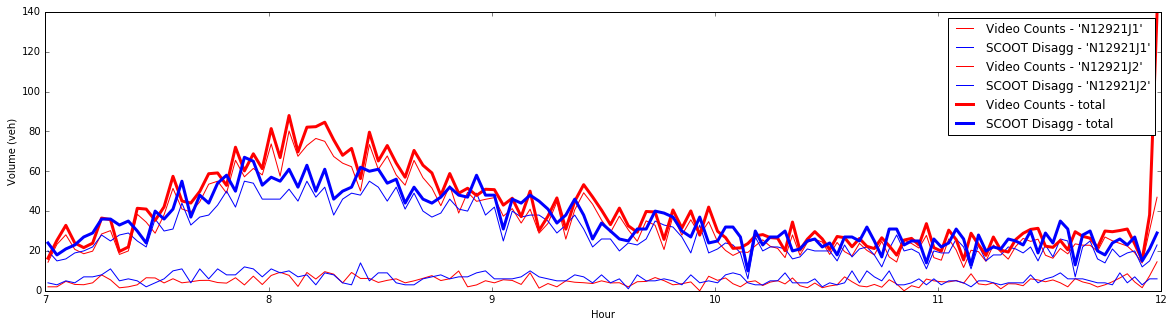

In [99]:
start_hour = 7
start_min = 0
start_sec = 0
end_hour = 11
end_min = 59
end_sec = 59
offset = 0
plt.subplots(figsize=[20,5]) 

print('Bins = SCOOT Cycles, Video Offset =', offset, 'sec')
start_time_sec = start_hour * 3600 + start_min * 60 + start_sec
end_time_sec = end_hour * 3600 + end_min * 60 + end_sec

# Time Filter
s = scoot[(scoot['seconds']>=start_time_sec) & (scoot['seconds']<=end_time_sec)].copy()
r = video[(video['seconds']>=start_time_sec-offset) & (video['seconds']<=end_time_sec-offset)].copy()

# Offset video 
r['seconds']=r['seconds']+offset

# Reset Index
s.reset_index(inplace=True,drop=True)
r.reset_index(inplace=True,drop=True)

# Plot Individual Detectors
for det in range(len(sdetectors)):
    s0 = s[s['detector'] == sdetectors[det].strip('\'')]
    min_bins_start = list(s0['seconds'])
    min_bins_start.append(s0['seconds'].values[-1]+s0['CycleTime'].values[-1])

    v = aggregate_data(min_bins_start,r,'detector'+str(det))
    plt.plot([x/3600 for x in min_bins_start[:-1]],v,'r',label='Video Counts - ' + sdetectors[det])
    plt.plot([x/3600 for x in min_bins_start[:-1]],s0['Volume'],'b',label='SCOOT Disagg - '+ sdetectors[det])

# Plot Total
s = s.groupby(['seconds'], as_index=False).sum()
min_bins_start = list(s['seconds'])
min_bins_start.append(s['seconds'].values[-1]+s['CycleTime'].values[-1])
v = aggregate_data(min_bins_start,r,'Volume')
plt.plot([x/3600 for x in min_bins_start[:-1]],v,'r',label='Video Counts - total',linewidth=3)
plt.plot([x/3600 for x in min_bins_start[:-1]],s['Volume'],'b',label='SCOOT Disagg - total',linewidth=3)

plt.legend()
plt.ylabel('Volume (veh)')
plt.xlabel('Hour')
plt.show()


binsize = 60 seconds, Video Offset = 0 sec


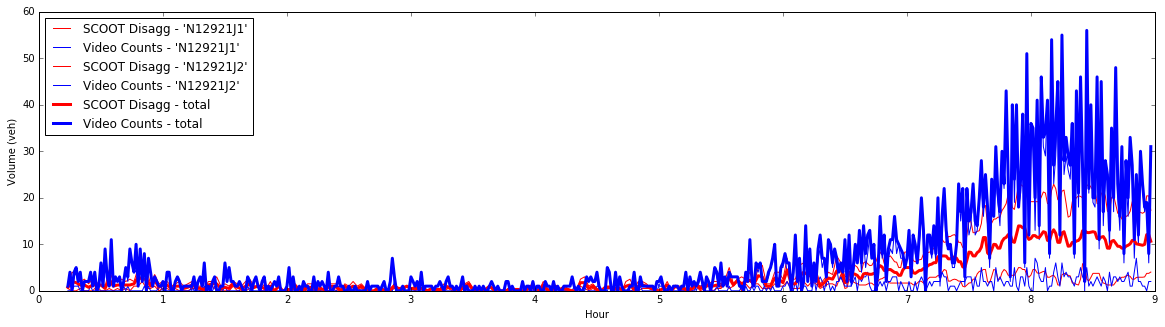

binsize = 120 seconds, Video Offset = 0 sec


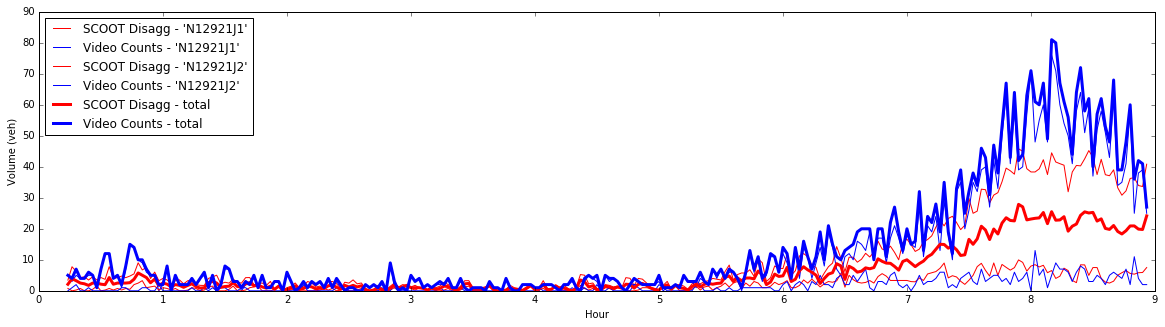

binsize = 180 seconds, Video Offset = 0 sec


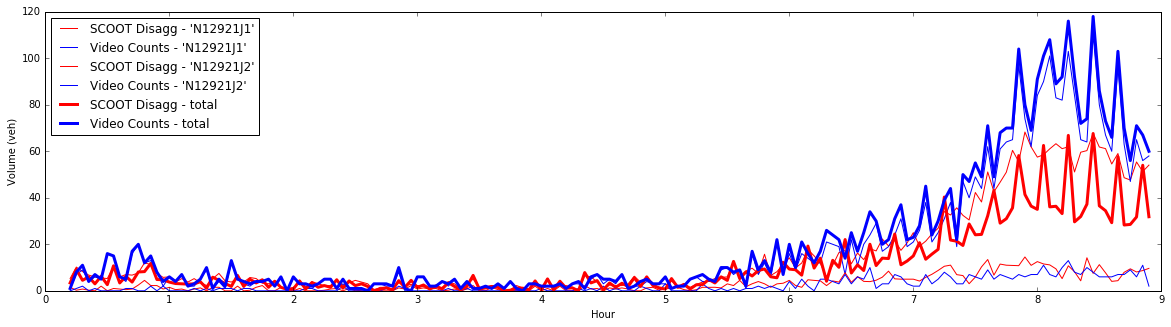

binsize = 300 seconds, Video Offset = 0 sec


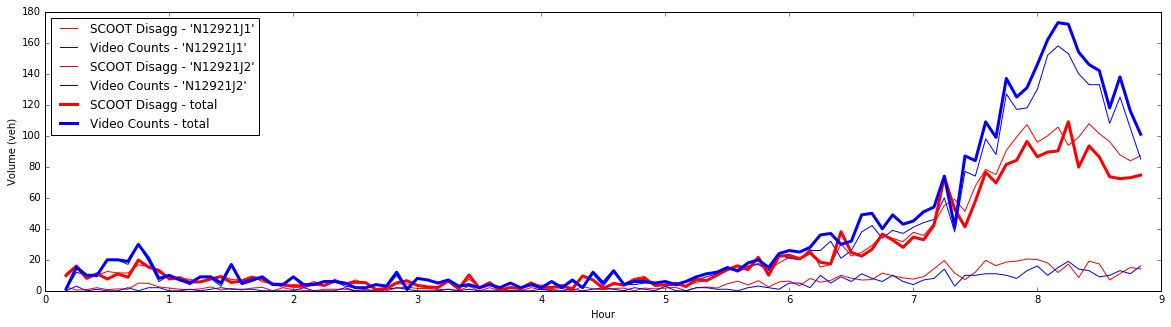

binsize = 900 seconds, Video Offset = 0 sec


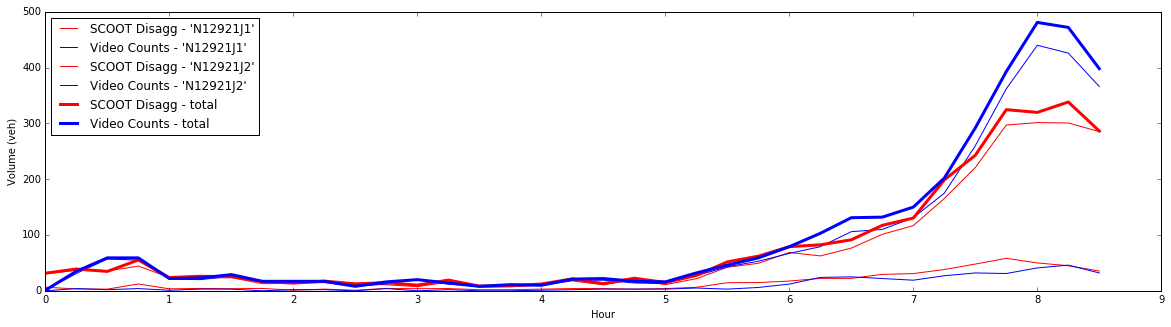

In [100]:
bin_sec_s=[60, 120, 180, 300, 900]
start_hour = 0
start_min = 0
start_sec = 0
end_hour = 8
end_min = 59
end_sec = 59
offset = 0

start_time_sec = start_hour * 3600 + start_min * 60 + start_sec
end_time_sec = end_hour * 3600 + end_min * 60 + end_sec
s = scoot.copy()
s.reset_index(inplace=True,drop=True)

for bin_sec in bin_sec_s:
    print('binsize =', bin_sec , 'seconds, Video Offset =', offset, 'sec')
    plt.subplots(figsize=(20,5))
    
    num_bins = (end_time_sec - start_time_sec)//bin_sec
    min_bins_start = list(np.linspace(start_time_sec, start_time_sec+bin_sec*num_bins, num_bins+1))
    r = video.copy()
    # Offset video 
    r['seconds']=r['seconds']+offset
    # Create bin index
    r['bin'] = r['seconds']//bin_sec
    
    r['seconds'] = r['bin']*bin_sec
    r = r[(r['seconds']>=start_time_sec) & (r['seconds']<=(end_time_sec-bin_sec))]
    min_bins_start = [x for x in min_bins_start if (x in list(r['seconds']) or x==start_time_sec+bin_sec*num_bins)]
    r = r.groupby(['centreline_id','dir_bin','count_date','bin'], as_index=False).sum()
    
    for det in range(len(sdetectors)):
        
        v = aggregate_data(min_bins_start, s[s['detector'] == sdetectors[det].strip('\'')],'Volume')

        plt.plot([x/3600 for x in min_bins_start[:-1]],v,'r',label='SCOOT Disagg - ' + sdetectors[det])
        plt.plot([x/3600 for x in min_bins_start[:-1]],r['detector'+str(det)],'b',label='Video Counts - ' + sdetectors[det])
    
    s0 = s.groupby(['seconds'], as_index=False).sum()
    v = aggregate_data(min_bins_start, s0, 'Volume')

    plt.plot([x/3600 for x in min_bins_start[:-1]],v,'r', label='SCOOT Disagg - total',linewidth=3)
    plt.plot([x/3600 for x in min_bins_start[:-1]],r['Volume'],'b', label='Video Counts - total', linewidth=3)
    
    '''
    # Add in aggregated SCOOT data if plotting 15min bins
    if bin_sec==900:
        scoot_agg = pd.read_table('DETS_CURRENT_MONTH.TXT', delim_whitespace=True,error_bad_lines=False,skiprows=9,header=None, 
                              names=['detector','dow','date','start','end','Volume','occ'])

        scoot_agg = scoot_agg[scoot_agg['date']==20170215]
        scoot_agg = scoot_agg[scoot_agg['detector']=='N30421B1']
        scoot_agg['seconds'] = scoot_agg['start'].str[:2].astype(int)*3600 + (scoot_agg['start'].str[-2:].astype(int)*60)
        scoot_agg = scoot_agg[scoot_agg['seconds'].isin(min_bins_start)]
        plt.plot([x/3600 for x in scoot_agg['seconds']],[y/4 for y in scoot_agg['Volume']],label='SCOOT Agg')
    '''
    plt.ylabel('Volume (veh)')
    plt.xlabel('Hour')
    plt.legend(loc=2)
    plt.show()